In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

In [161]:

df = pd.read_csv('./Raw_Data_for_train_test.csv')
print(f"Размерность датасета: {df.shape}")

df

Размерность датасета: (19372, 50)


,TARGET_B,TARGET_D,CONTROL_NUMBER,MONTHS_SINCE_ORIGIN,DONOR_AGE,IN_HOUSE,URBANICITY,SES,CLUSTER_CODE,HOME_OWNER,...,LIFETIME_GIFT_RANGE,LIFETIME_MAX_GIFT_AMT,LIFETIME_MIN_GIFT_AMT,LAST_GIFT_AMT,CARD_PROM_12,NUMBER_PROM_12,MONTHS_SINCE_LAST_GIFT,MONTHS_SINCE_FIRST_GIFT,FILE_AVG_GIFT,FILE_CARD_GIFT
0,0,NaN,5,101,87.0,0,?,?,.,H,...,15.0,20.0,5.0,15.0,5,12,26,92,8.49,7
1,1,10.0,12,137,79.0,0,R,2,45,H,...,20.0,25.0,5.0,17.0,7,21,7,122,14.72,12
2,0,NaN,37,113,75.0,0,S,1,11,H,...,23.0,28.0,5.0,19.0,11,32,6,105,16.75,16
3,0,NaN,38,92,NaN,0,U,2,4,H,...,14.0,17.0,3.0,15.0,11,33,6,92,11.76,12
4,0,NaN,41,101,74.0,0,R,2,49,U,...,20.0,25.0,5.0,25.0,6,19,18,92,8.83,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19367,0,NaN,191687,89,66.0,1,U,1,3,H,...,22.0,25.0,3.0,15.0,6,13,18,81,17.17,3
19368,0,NaN,191710,137,77.0,1,C,1,24,H,...,9.0,10.0,1.0,10.0,6,13,21,130,7.81,13
19369,0,NaN,191746,29,NaN,1,S,1,11,U,...,0.0,15.0,15.0,15.0,3,9,23,23,15.00,0
19370,0,NaN,191775,129,78.0,1,?,?,.,U,...,20.0,25.0,5.0,25.0,7,24,8,129,18.33,11


In [162]:
df.TARGET_D.fillna(0, inplace=True)

In [163]:
print(f"Общее количество наблюдений: {len(df)}")

Общее количество наблюдений: 19372


In [164]:
#Убираем мультиколлинеарность
df.drop('INCOME_GROUP', axis=1, inplace=True);
df.drop('MEDIAN_HOUSEHOLD_INCOME', axis=1, inplace=True);
df.drop('RECENT_RESPONSE_PROP', axis=1, inplace=True);
df.drop('PER_CAPITA_INCOME', axis=1, inplace=True);
df.drop('RECENT_STAR_STATUS', axis=1, inplace=True);
df.drop('PEP_STAR', axis=1, inplace=True);
df.drop('PCT_ATTRIBUTE3', axis=1, inplace=True);
df.drop('LIFETIME_GIFT_AMOUNT', axis=1, inplace=True);
df.drop('MONTHS_SINCE_LAST_PROM_RESP', axis=1, inplace=True);
df.drop('LIFETIME_MAX_GIFT_AMT', axis=1, inplace=True);
df.drop('RECENT_RESPONSE_COUNT', axis=1, inplace=True);
df.drop('LIFETIME_PROM', axis=1, inplace=True);
df.drop('LAST_GIFT_AMT', axis=1, inplace=True);
df.drop('WEALTH_RATING', axis=1, inplace=True);
df.drop('CONTROL_NUMBER', axis=1, inplace=True);

In [165]:
#Разделим выборку на батчи для построения более миниатюрных рисунков.
batch1 = ['TARGET_B', 'TARGET_D', 'MONTHS_SINCE_ORIGIN',
          'DONOR_AGE', 'IN_HOUSE', 'URBANICITY', 'SES', 'CLUSTER_CODE',
          'HOME_OWNER', 'DONOR_GENDER', 'PUBLISHED_PHONE',
          'OVERLAY_SOURCE', 'MOR_HIT_RATE', 'MEDIAN_HOME_VALUE', 'PCT_OWNER_OCCUPIED',
          'PCT_ATTRIBUTE1', 'PCT_ATTRIBUTE2', 'PCT_ATTRIBUTE4',
          'RECENCY_STATUS_96NK',
          'FREQUENCY_STATUS_97NK', 'RECENT_AVG_GIFT_AMT']

batch2 = ['TARGET_B', 'TARGET_D', 'RECENT_CARD_RESPONSE_PROP', 'RECENT_AVG_CARD_GIFT_AMT',
          'RECENT_CARD_RESPONSE_COUNT',
          'LIFETIME_CARD_PROM', 'LIFETIME_GIFT_COUNT', 'LIFETIME_AVG_GIFT_AMT',
          'LIFETIME_GIFT_RANGE', 'LIFETIME_MIN_GIFT_AMT',
          'CARD_PROM_12', 'NUMBER_PROM_12',
          'MONTHS_SINCE_LAST_GIFT', 'MONTHS_SINCE_FIRST_GIFT', 'FILE_AVG_GIFT',
          'FILE_CARD_GIFT']

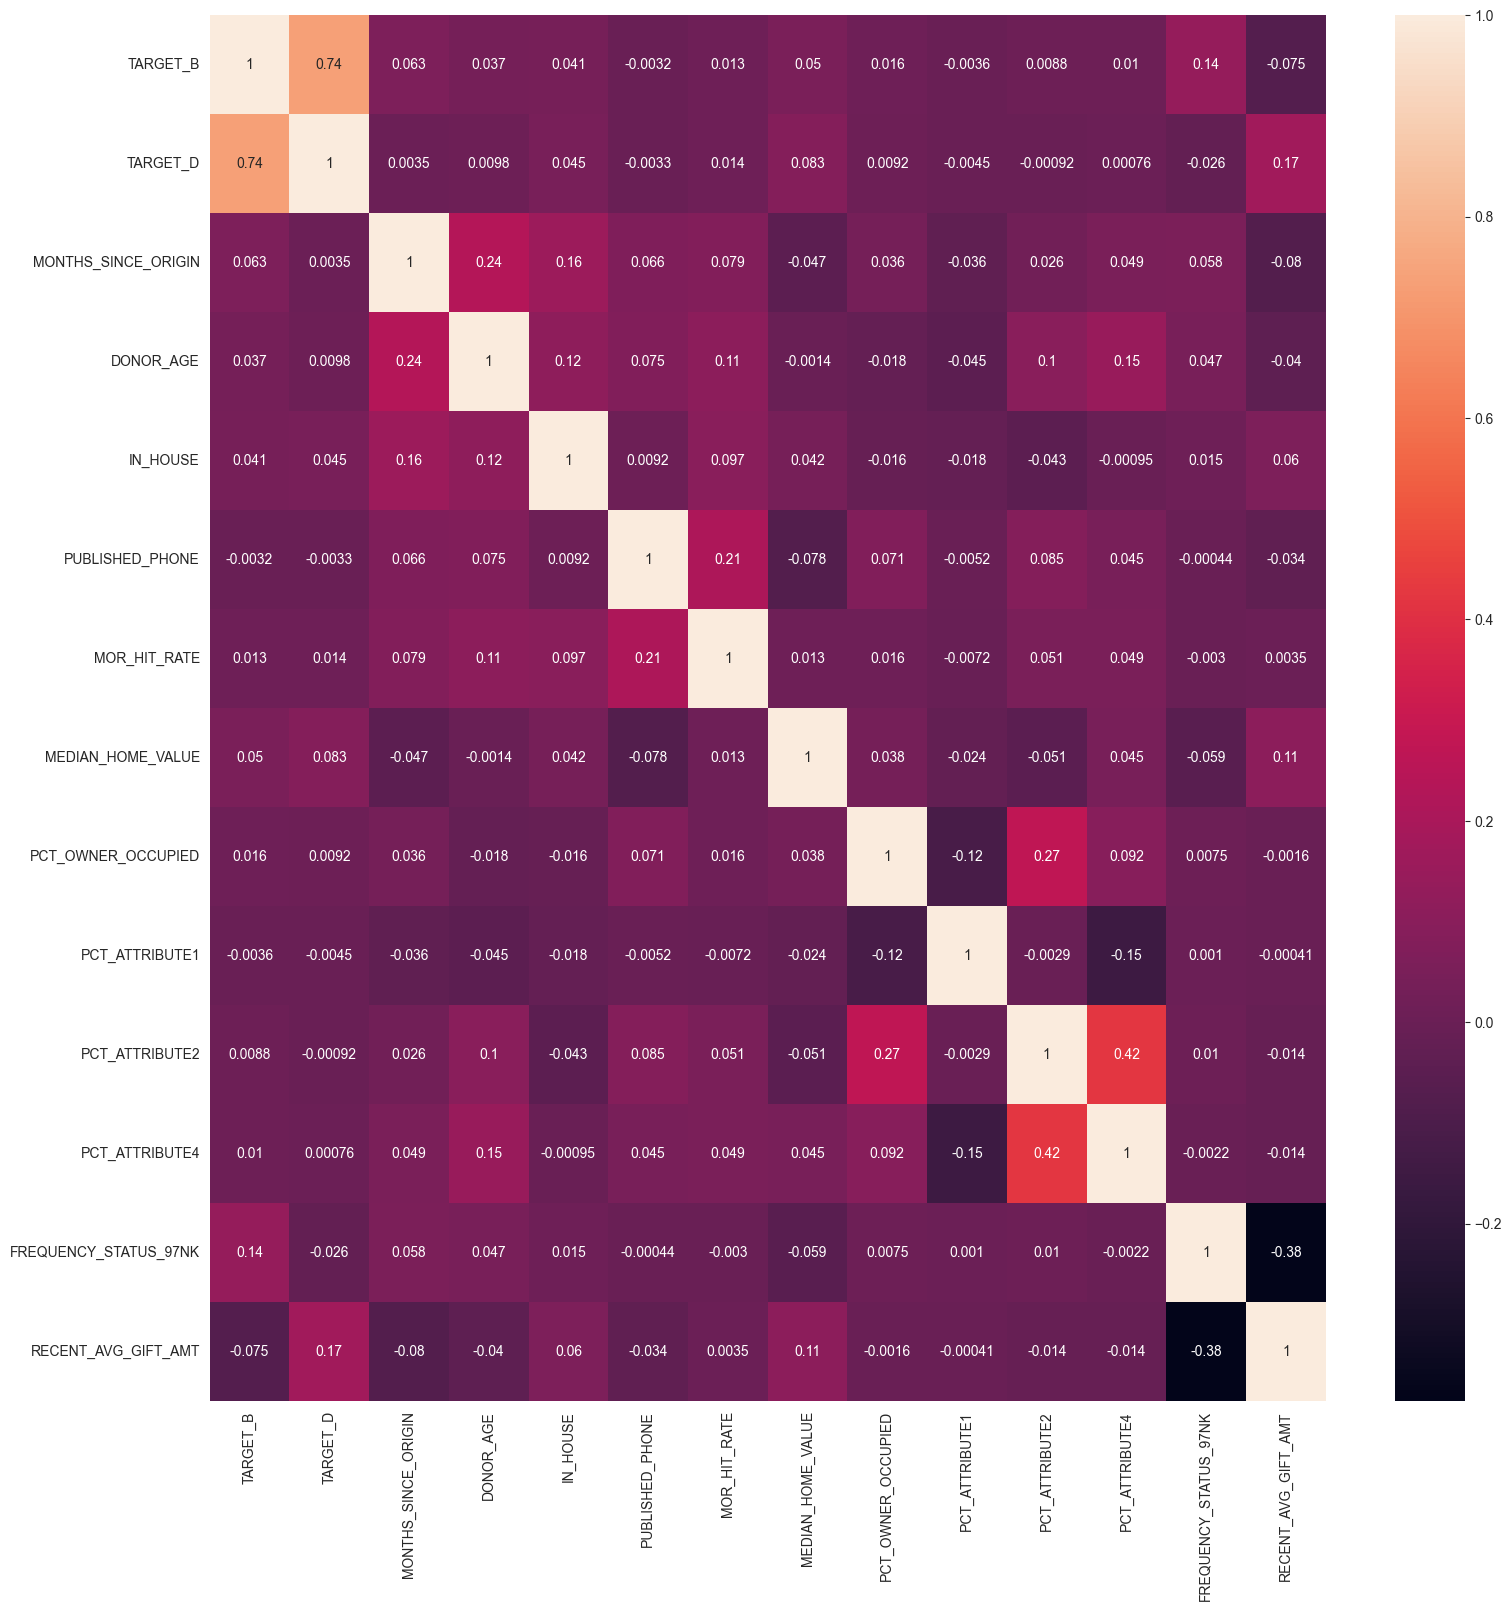

In [166]:
import seaborn as sns

plt.rcParams["figure.figsize"] = 18, 18

# все колонки имеют ненормальное распределение, поэтому используем ранговый коэффициент Спирмена
# аргумент annot функции heatmap() включает отображение значений в ячейках
sns.heatmap(df[batch1].corr(method="pearson", numeric_only=True), annot=True);

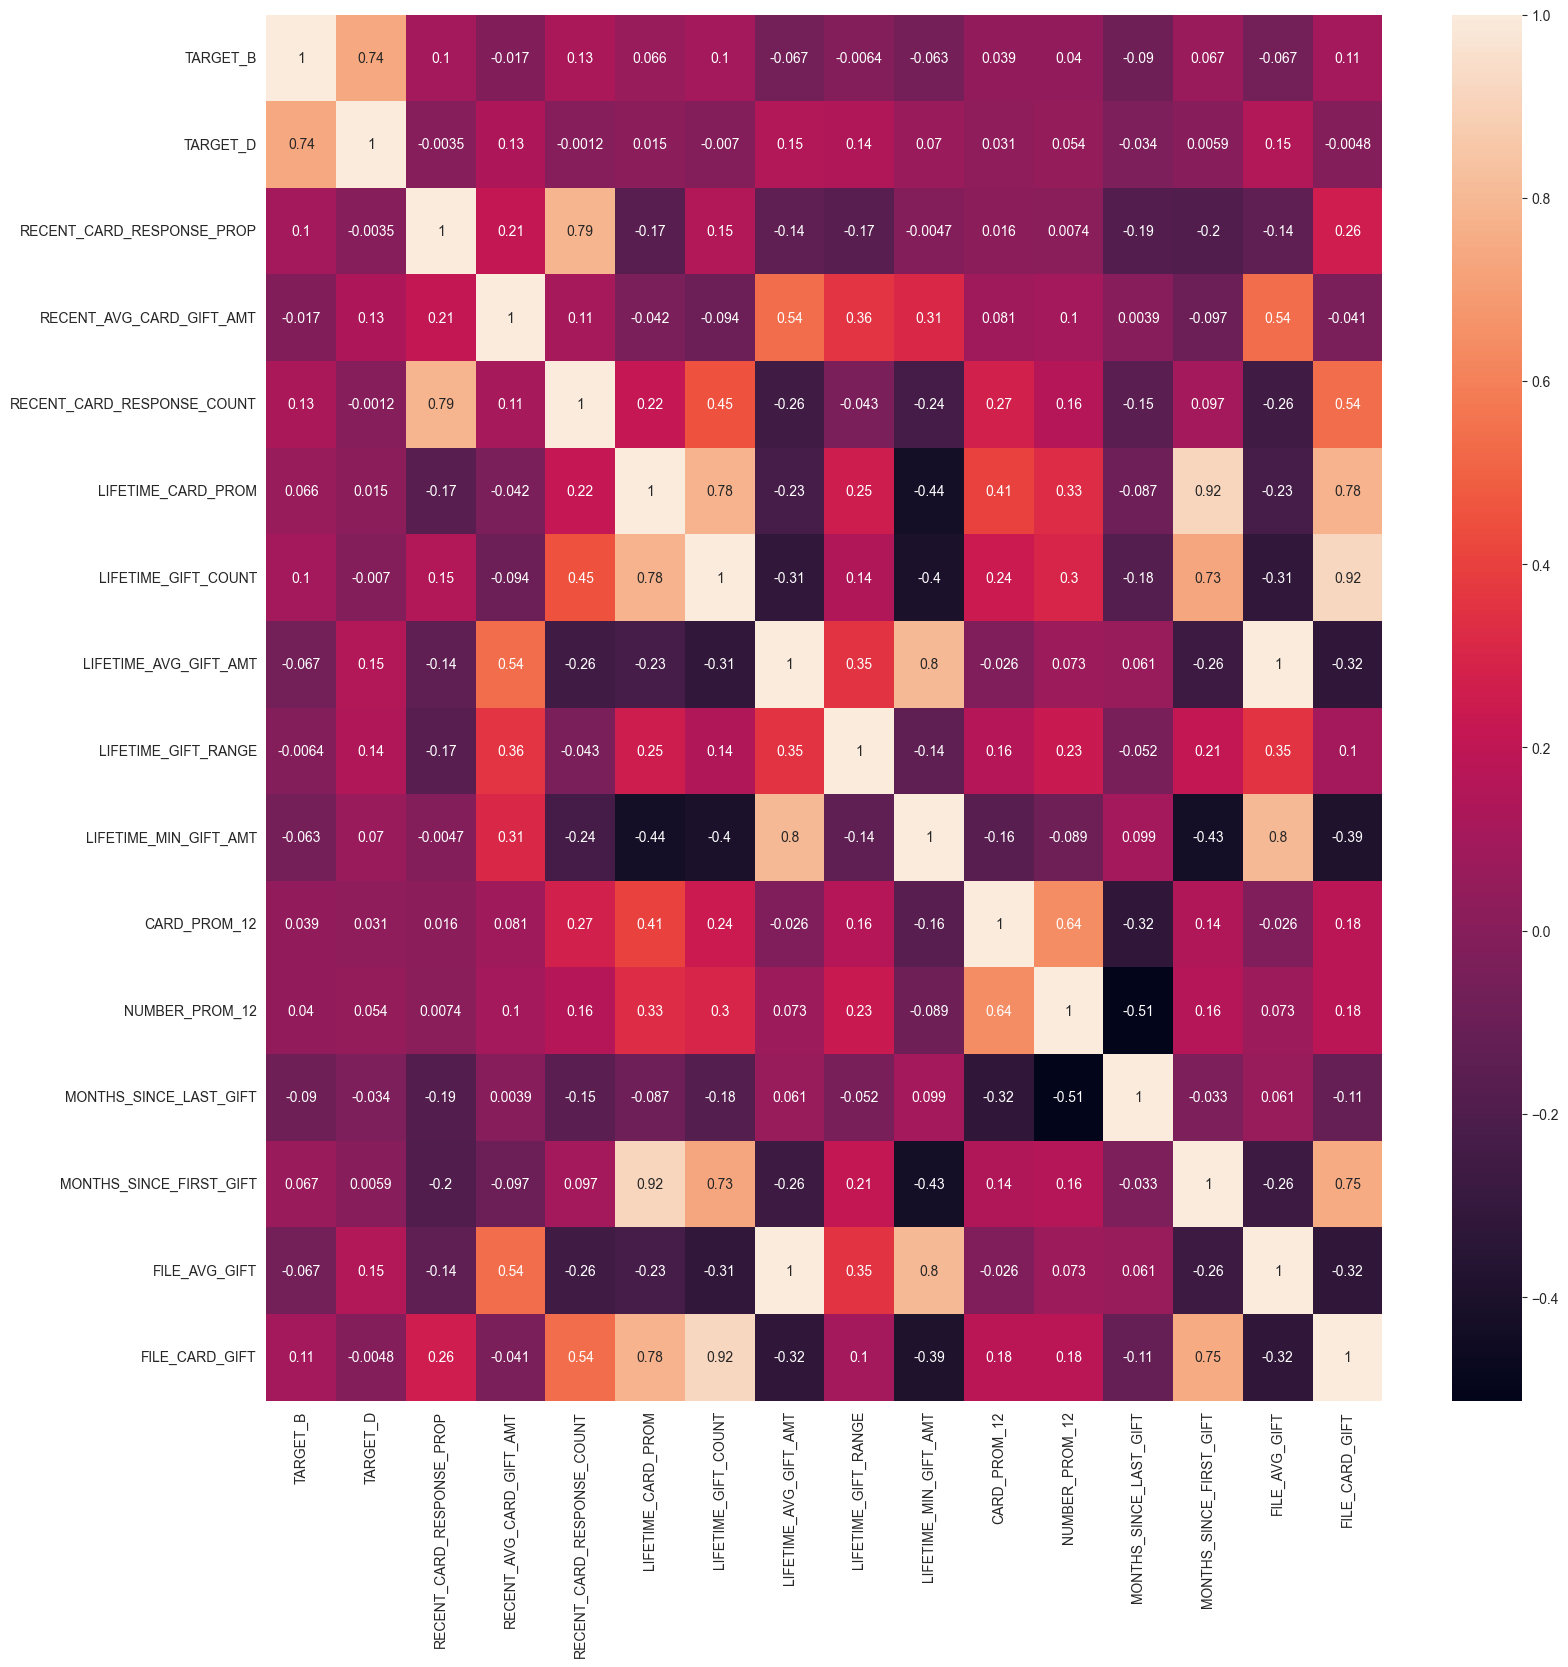

In [167]:
sns.heatmap(df[batch2].corr(method="pearson", numeric_only=True), annot=True);

In [168]:
#Проверим данные на наличие пропусков
df.isna().sum() / len(df)

TARGET_B                      0.000000
TARGET_D                      0.000000
MONTHS_SINCE_ORIGIN           0.000000
DONOR_AGE                     0.247522
IN_HOUSE                      0.000000
URBANICITY                    0.000000
SES                           0.000000
CLUSTER_CODE                  0.000000
HOME_OWNER                    0.000000
DONOR_GENDER                  0.000000
PUBLISHED_PHONE               0.000000
OVERLAY_SOURCE                0.000000
MOR_HIT_RATE                  0.000000
MEDIAN_HOME_VALUE             0.000000
PCT_OWNER_OCCUPIED            0.000000
PCT_ATTRIBUTE1                0.000000
PCT_ATTRIBUTE2                0.000000
PCT_ATTRIBUTE4                0.000000
RECENCY_STATUS_96NK           0.000000
FREQUENCY_STATUS_97NK         0.000000
RECENT_AVG_GIFT_AMT           0.000000
RECENT_CARD_RESPONSE_PROP     0.000000
RECENT_AVG_CARD_GIFT_AMT      0.000000
RECENT_CARD_RESPONSE_COUNT    0.000000
LIFETIME_CARD_PROM            0.000000
LIFETIME_GIFT_COUNT      

In [169]:
df.dtypes

TARGET_B                        int64
TARGET_D                      float64
MONTHS_SINCE_ORIGIN             int64
DONOR_AGE                     float64
IN_HOUSE                        int64
URBANICITY                     object
SES                            object
CLUSTER_CODE                   object
HOME_OWNER                     object
DONOR_GENDER                   object
PUBLISHED_PHONE                 int64
OVERLAY_SOURCE                 object
MOR_HIT_RATE                    int64
MEDIAN_HOME_VALUE               int64
PCT_OWNER_OCCUPIED              int64
PCT_ATTRIBUTE1                  int64
PCT_ATTRIBUTE2                  int64
PCT_ATTRIBUTE4                  int64
RECENCY_STATUS_96NK            object
FREQUENCY_STATUS_97NK           int64
RECENT_AVG_GIFT_AMT           float64
RECENT_CARD_RESPONSE_PROP     float64
RECENT_AVG_CARD_GIFT_AMT      float64
RECENT_CARD_RESPONSE_COUNT      int64
LIFETIME_CARD_PROM              int64
LIFETIME_GIFT_COUNT             int64
LIFETIME_AVG

In [170]:
#Заменим отсутствующие значения на среднее значение
df['DONOR_AGE'].replace('NaN', np.nan, inplace=True)
df['DONOR_AGE'].fillna(df.DONOR_AGE.mean(), inplace=True)

In [171]:
#Посмотрим на соотношение классов:
print('Доноры составляют', round(df['TARGET_B'].value_counts()[1] / len(df) * 100, 2), '% данных')
print('Не доноры составляют', round(df['TARGET_B'].value_counts()[0] / len(df) * 100, 2), '% данных')

Доноры составляют 25.0 % данных
Не доноры составляют 75.0 % данных


Text(0.5, 1.0, 'Распределение классов \n (0: Не догор || 1: Донор)')

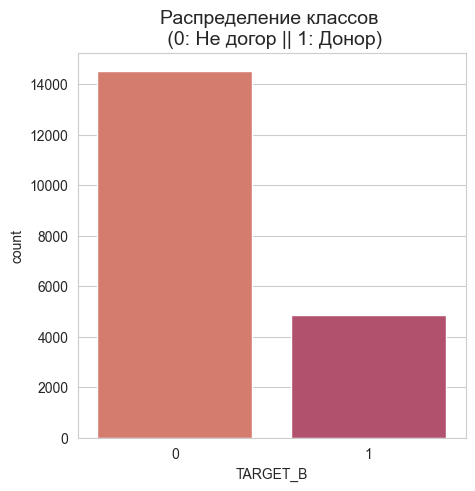

In [172]:
plt.rcParams["figure.figsize"] = 5, 5  # ширина, высота
sns.countplot(x='TARGET_B', data=df,
              palette=sns.color_palette("flare", n_colors=3))  # строим гистограмму целевой переменной
plt.title('Распределение классов \n (0: Не догор || 1: Донор)', fontsize=14)

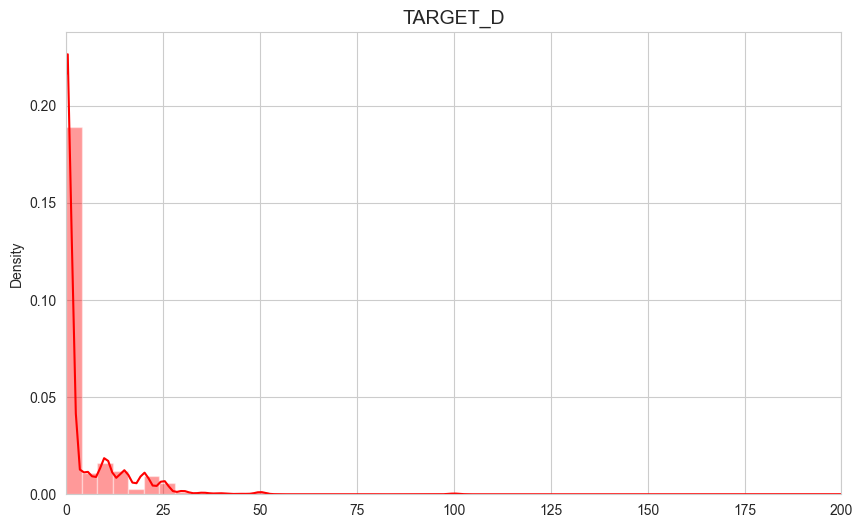

In [173]:
fig, ax = plt.subplots(figsize=(10, 6))

target_d = df['TARGET_D'].values

sns.distplot(target_d, ax=ax, color='r')
ax.set_title('TARGET_D', fontsize=14)
ax.set_xlim([min(target_d), max(target_d)])

plt.show()

In [174]:
tar_list = []

for i, col in enumerate(df[1:]):
    if len(df[col].value_counts()) < 4:
        tar_list.append(col)

print(tar_list)

['TARGET_B', 'IN_HOUSE', 'HOME_OWNER', 'PUBLISHED_PHONE']


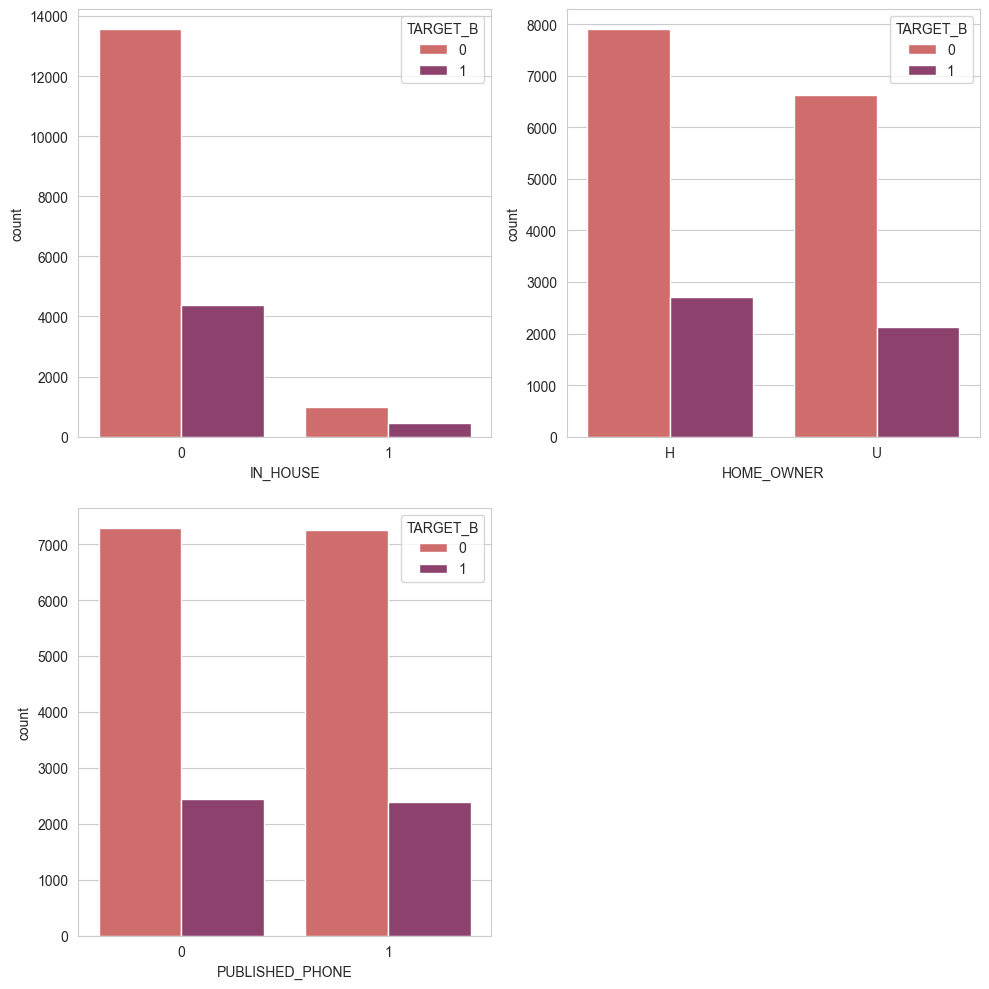

In [175]:
plt.figure(figsize=(10, 10))

for i, col in enumerate(tar_list[1:]):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=col, hue="TARGET_B", data=df, palette=sns.color_palette("flare", n_colors=2))
    plt.tight_layout(h_pad=2)

In [176]:
tar_list2 = []

for i, col in enumerate(df[1:]):
    if len(df[col].value_counts()) >= 4:
        tar_list2.append(col)

print(len(tar_list2))
print(tar_list2)

31
['TARGET_D', 'MONTHS_SINCE_ORIGIN', 'DONOR_AGE', 'URBANICITY', 'SES', 'CLUSTER_CODE', 'DONOR_GENDER', 'OVERLAY_SOURCE', 'MOR_HIT_RATE', 'MEDIAN_HOME_VALUE', 'PCT_OWNER_OCCUPIED', 'PCT_ATTRIBUTE1', 'PCT_ATTRIBUTE2', 'PCT_ATTRIBUTE4', 'RECENCY_STATUS_96NK', 'FREQUENCY_STATUS_97NK', 'RECENT_AVG_GIFT_AMT', 'RECENT_CARD_RESPONSE_PROP', 'RECENT_AVG_CARD_GIFT_AMT', 'RECENT_CARD_RESPONSE_COUNT', 'LIFETIME_CARD_PROM', 'LIFETIME_GIFT_COUNT', 'LIFETIME_AVG_GIFT_AMT', 'LIFETIME_GIFT_RANGE', 'LIFETIME_MIN_GIFT_AMT', 'CARD_PROM_12', 'NUMBER_PROM_12', 'MONTHS_SINCE_LAST_GIFT', 'MONTHS_SINCE_FIRST_GIFT', 'FILE_AVG_GIFT', 'FILE_CARD_GIFT']


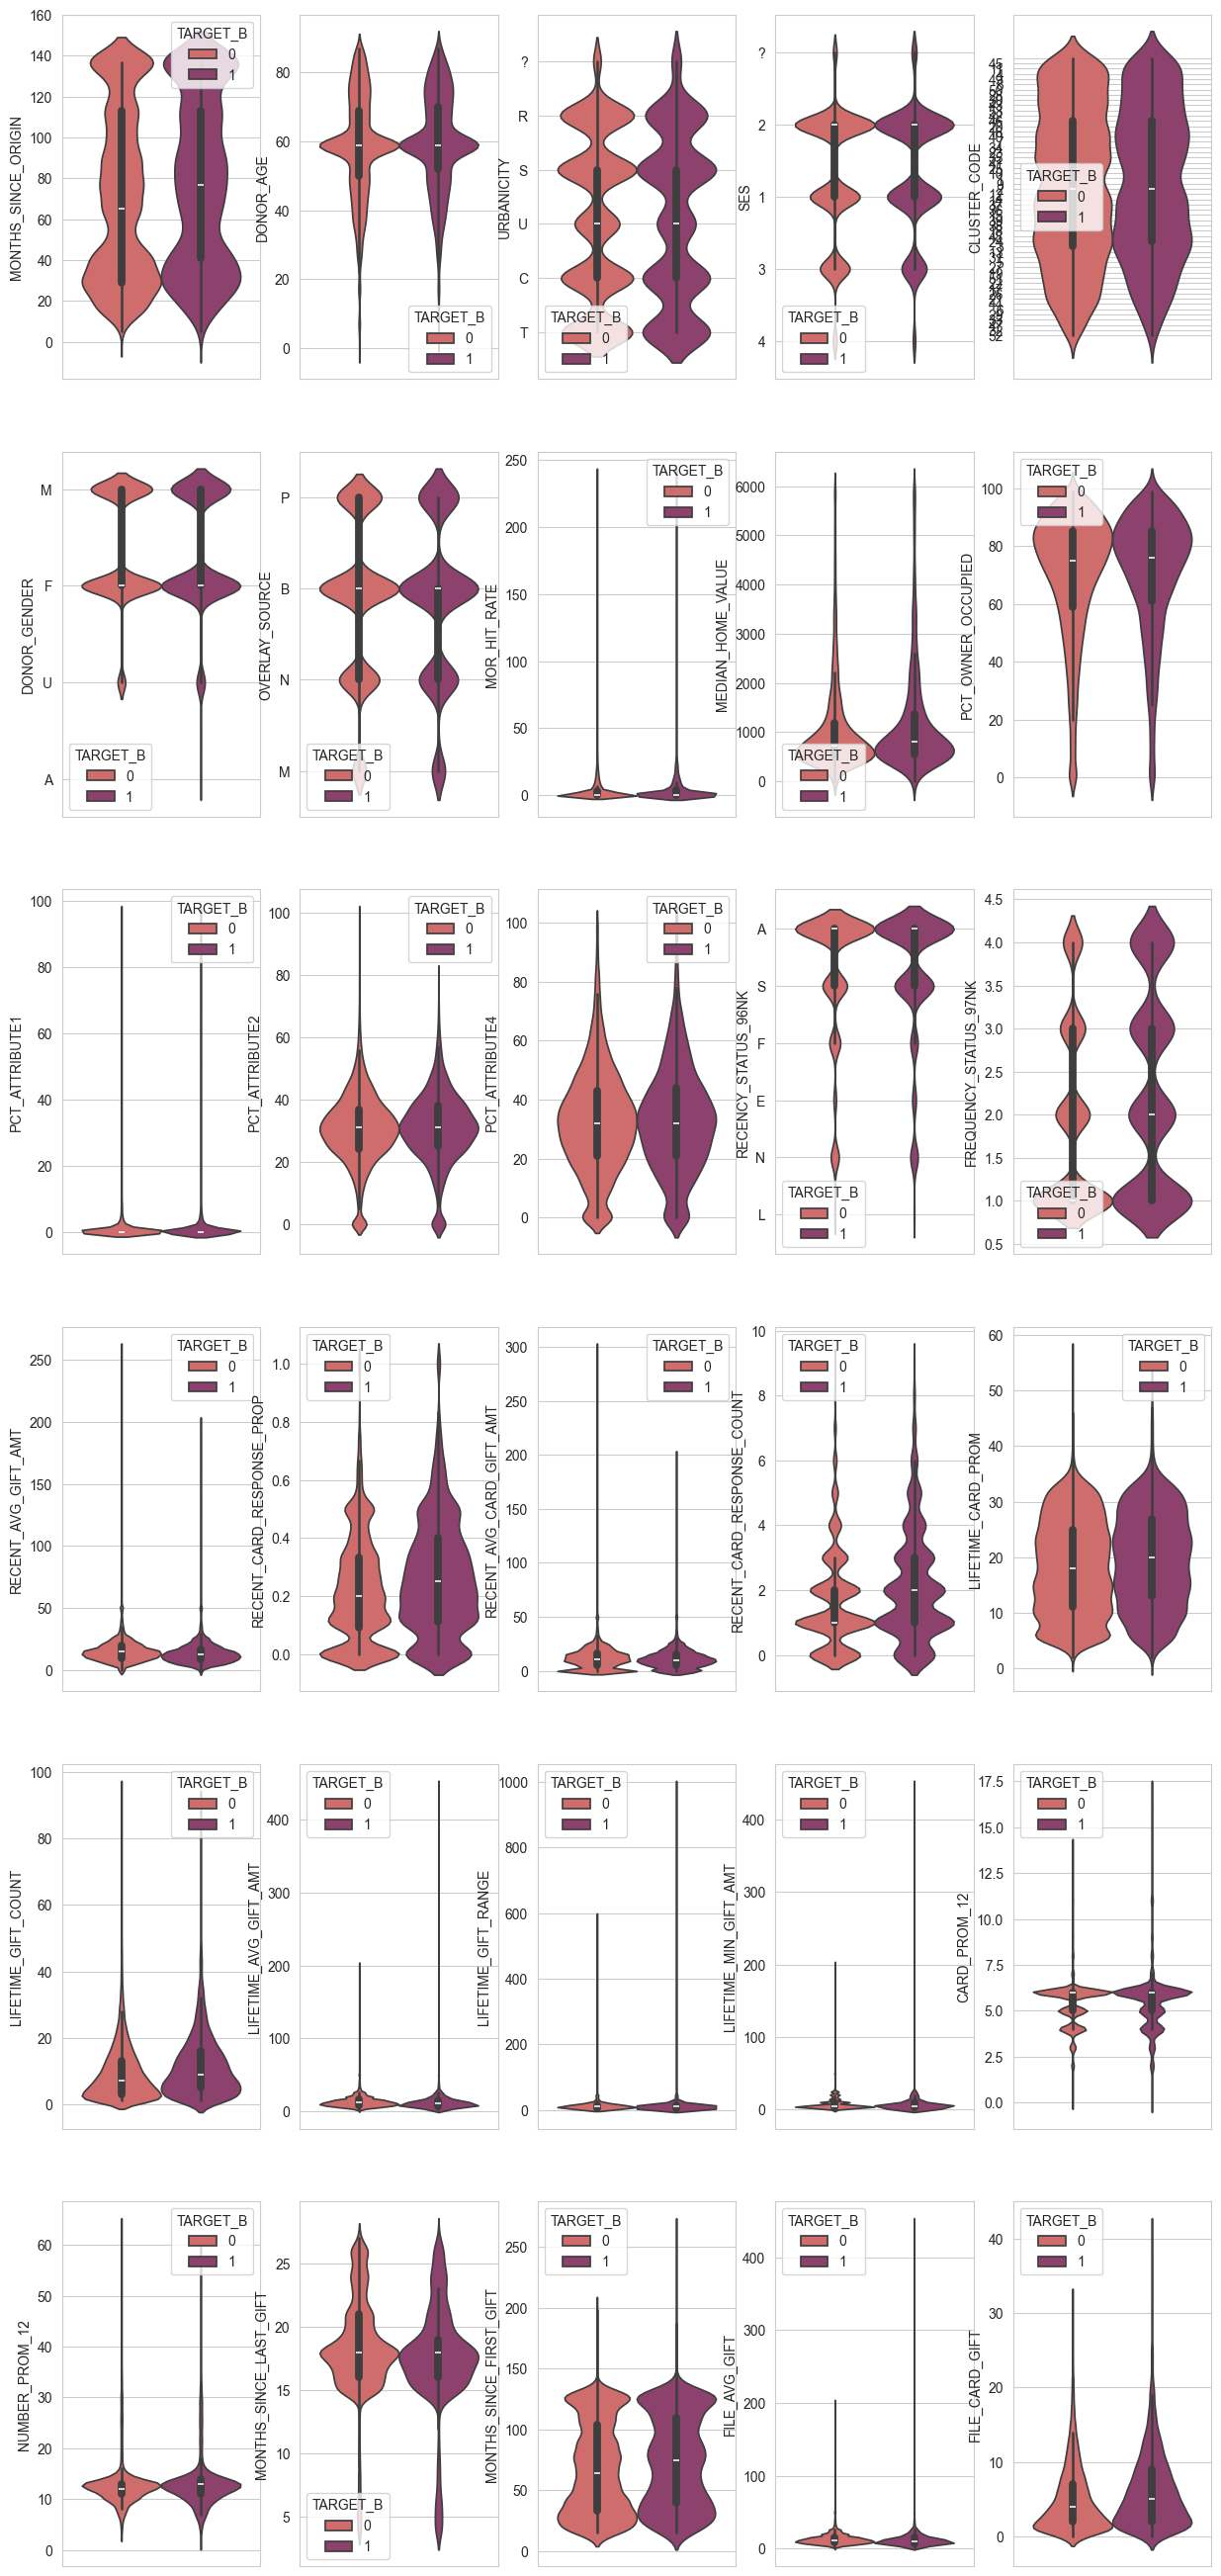

In [177]:
plt.rcParams["figure.figsize"] = 15, 40

plt.figure(figsize=(15, 45))

for i, col in enumerate(tar_list2[1:]):
    plt.subplot(8, 5, i + 1)
    sns.violinplot(y=col, hue="TARGET_B", data=df, palette=sns.color_palette("flare", n_colors=2))

In [289]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()  # Менее чувствителен к выбросам, чем просто стандартизация

X = df.drop('TARGET_B', axis=1)
y = df['TARGET_B']

numeric_cols = X.select_dtypes(include='number').columns
column_list_category = X.select_dtypes(include='object').columns

le = LabelEncoder()
for col in column_list_category:
    X[col] = le.fit_transform(X[col])

#Преобразуем так все колонки
for col in numeric_cols:
    X[col] = rob_scaler.fit_transform(X[col].values.reshape(-1, 1))
    X[col] = rob_scaler.fit_transform(X[col].values.reshape(-1, 1))

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state=42)
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label / len(original_ytrain))
print("Тестовый набор:", test_counts_label / len(original_ytest))

Распределение классов: 

Обучающий набор: [0.74911273 0.25088727]
Тестовый набор: [0.75354839 0.24645161]


## Метод Random Under-Sampling

In [206]:
df_normal = pd.concat([y, X], axis=1)
df_normal = df_normal.sample(frac=1)

fraud_df = df_normal.loc[df['TARGET_B'] == 1]
non_fraud_df = df_normal.loc[df['TARGET_B'] == 0][:4843]  # берем последние 4843 транзакции

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перемешивание строк датасета
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,TARGET_B,TARGET_D,MONTHS_SINCE_ORIGIN,DONOR_AGE,IN_HOUSE,URBANICITY,SES,CLUSTER_CODE,HOME_OWNER,DONOR_GENDER,...,LIFETIME_GIFT_COUNT,LIFETIME_AVG_GIFT_AMT,LIFETIME_GIFT_RANGE,LIFETIME_MIN_GIFT_AMT,CARD_PROM_12,NUMBER_PROM_12,MONTHS_SINCE_LAST_GIFT,MONTHS_SINCE_FIRST_GIFT,FILE_AVG_GIFT,FILE_CARD_GIFT
4900,0,0.0,0.571429,0.448942,0.0,4,0,29,0,1,...,0.0,0.078571,0.2,0.000000,-1.0,1.0,-0.25,0.638889,0.078571,0.000000
15680,0,0.0,0.857143,0.000000,0.0,5,1,50,1,1,...,0.8,-0.188571,1.7,-0.285714,0.0,0.5,-0.25,0.875000,-0.188571,1.333333
3838,0,0.0,0.142857,0.282275,0.0,5,0,1,1,2,...,-0.5,2.400000,0.0,2.571429,0.0,0.0,0.75,0.041667,2.400000,-0.166667
5449,0,0.0,-0.428571,0.504497,0.0,4,0,28,0,1,...,-0.2,-0.481429,-0.4,0.000000,0.0,0.5,0.25,-0.458333,-0.481429,-0.166667
19228,1,64.0,0.000000,0.448942,0.0,2,2,47,1,2,...,0.0,0.507143,-0.3,0.714286,-4.0,-4.0,-0.25,-0.125000,0.507143,0.333333


Распределение классов в подвыборке
TARGET_B
0    0.5
1    0.5
Name: count, dtype: float64


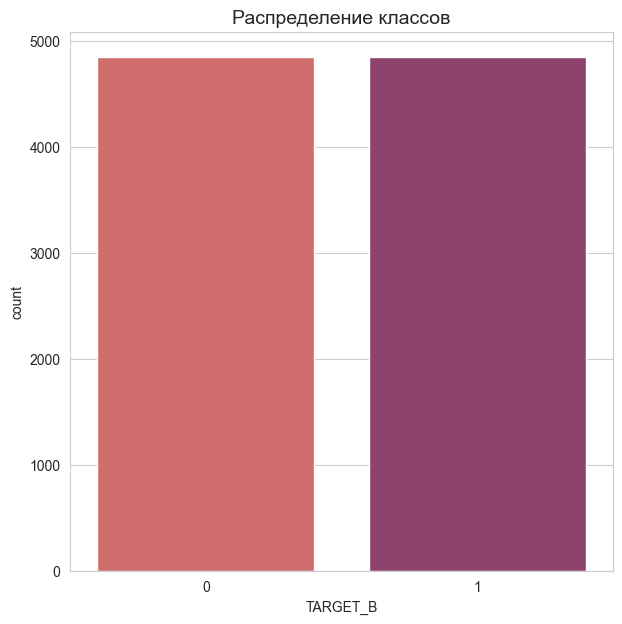

In [207]:
plt.figure(figsize=(7, 7))

print('Распределение классов в подвыборке')
print(new_df['TARGET_B'].value_counts() / len(new_df))

# проверяем снова распределение целевой переменной
sns.countplot(x='TARGET_B', data=new_df, palette=sns.color_palette("flare", n_colors=2))
plt.title('Распределение классов', fontsize=14)
plt.show()

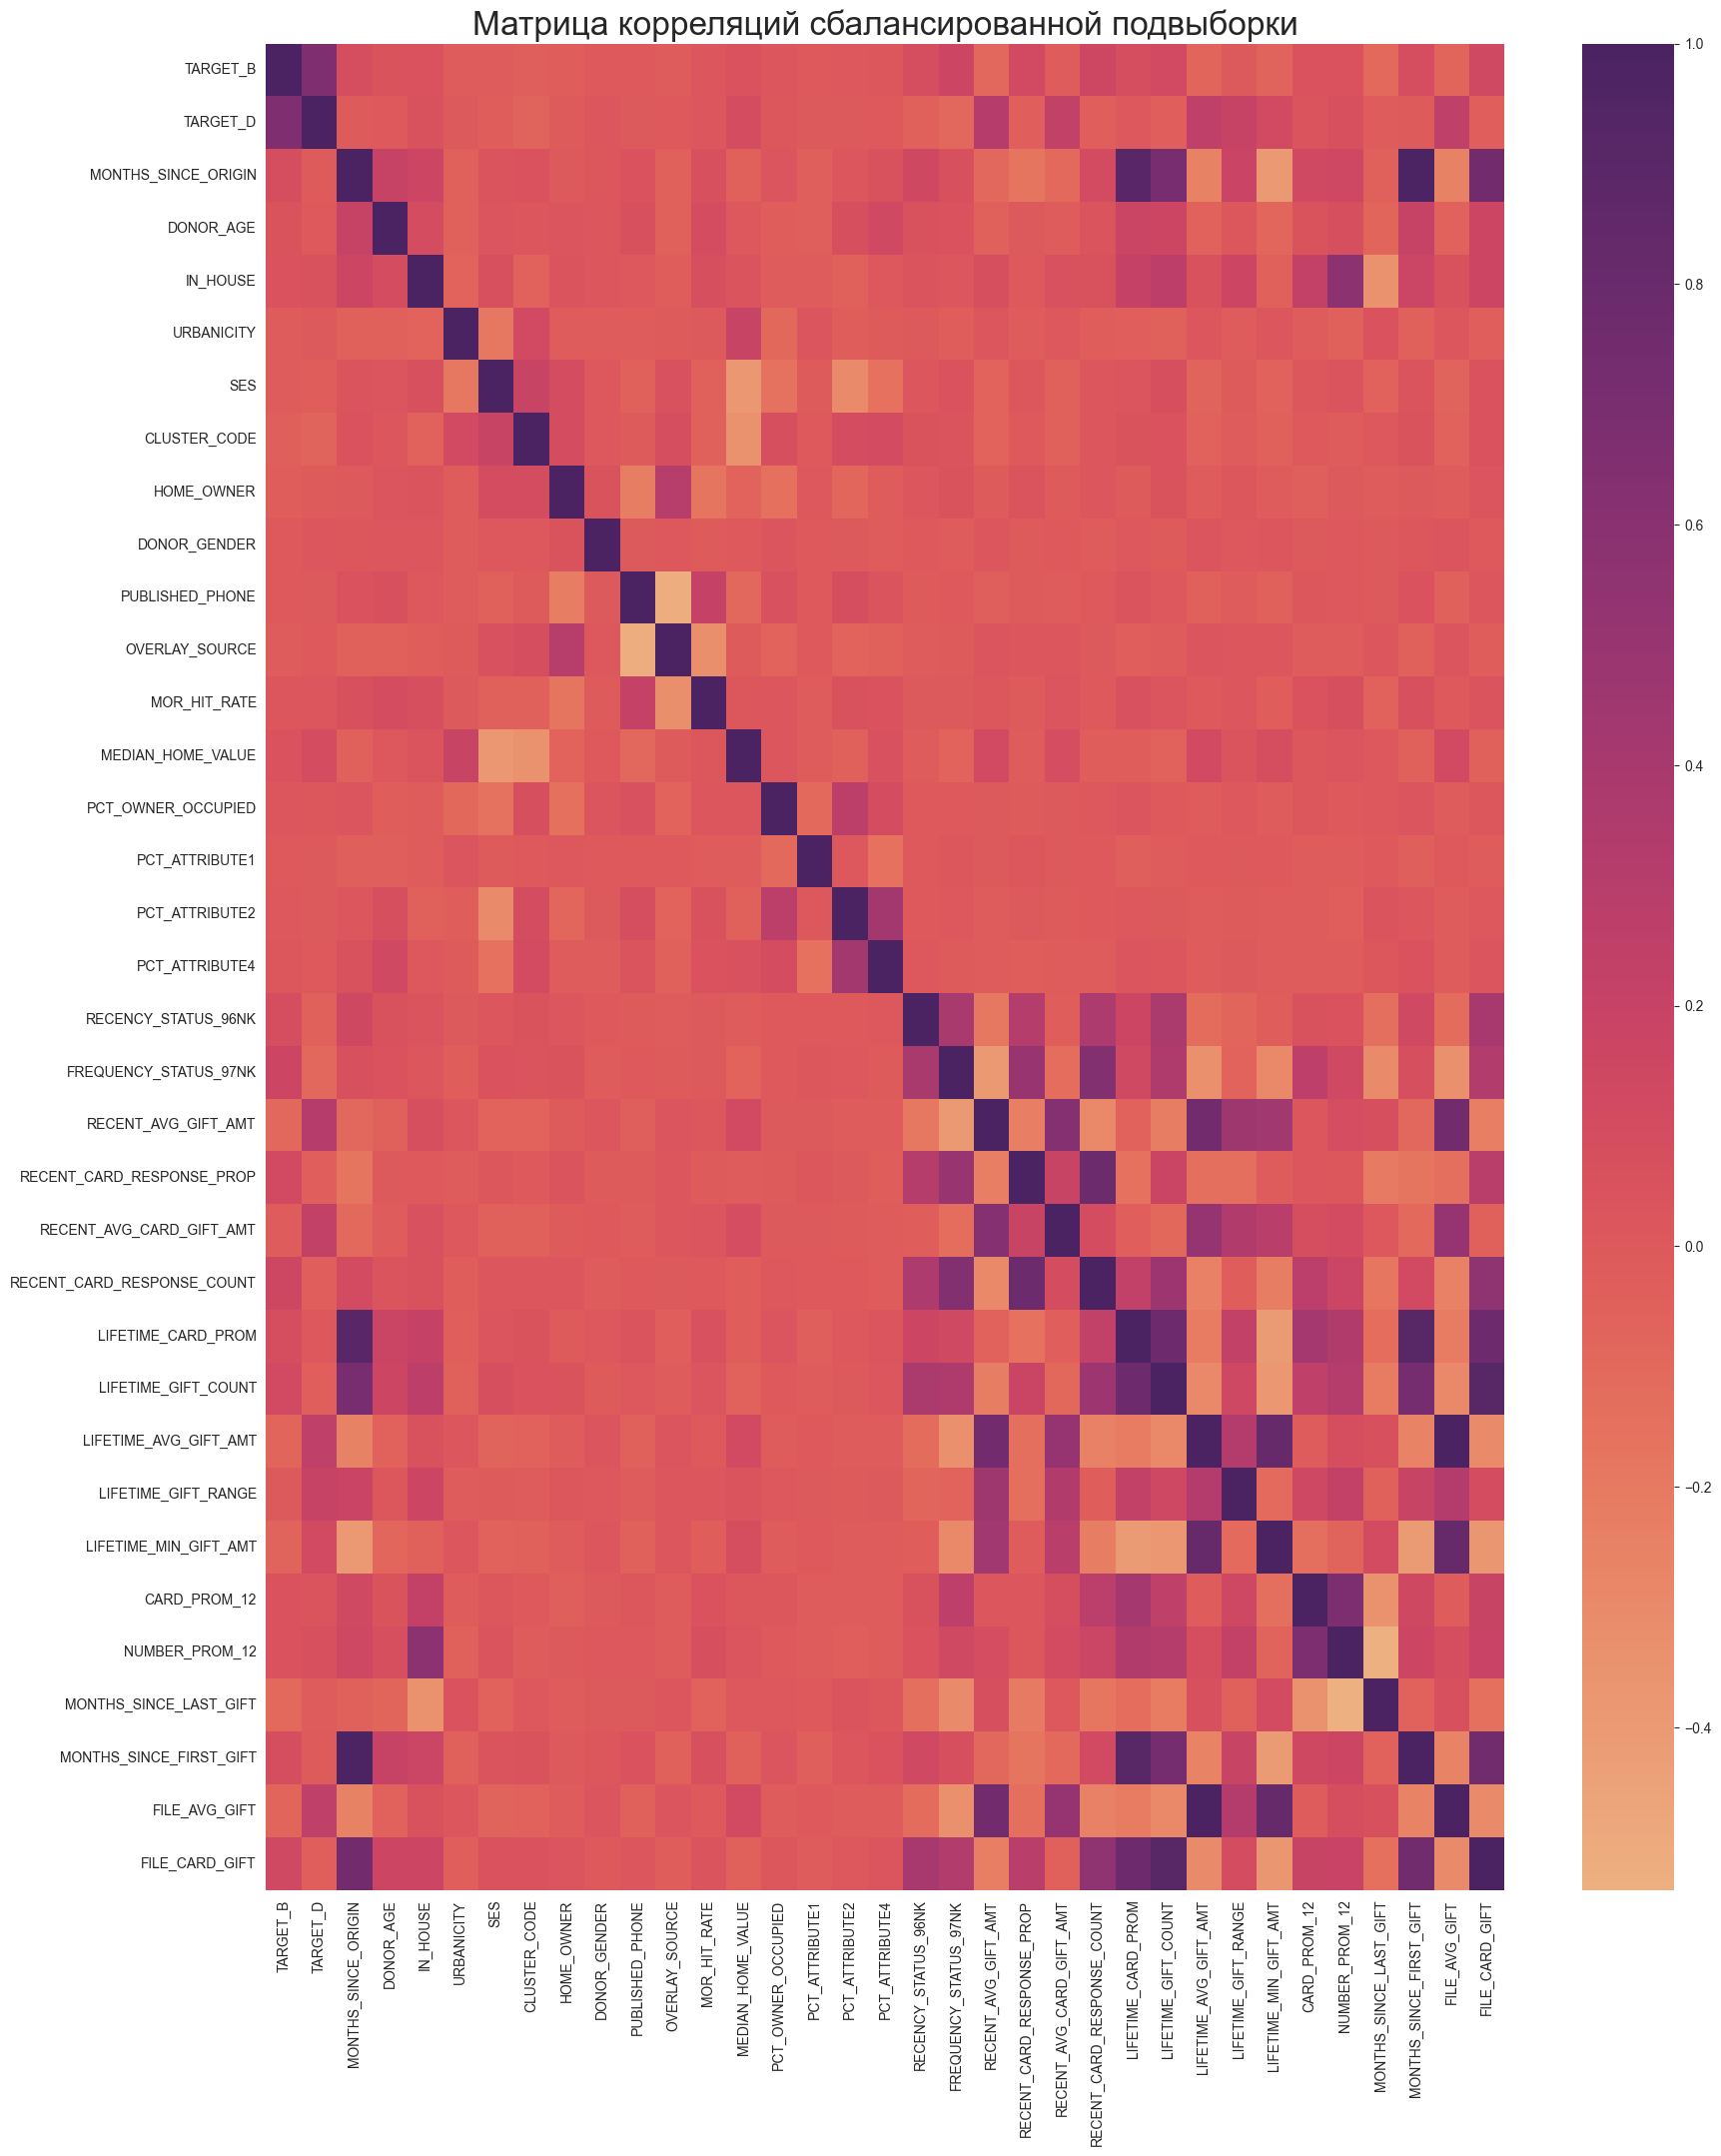

In [208]:
f, ax = plt.subplots(1, 1, figsize=(20, 24))

# Построим матрицу корреляций

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='flare', annot_kws={'size': 20}, ax=ax)
ax.set_title('Матрица корреляций сбалансированной подвыборки', fontsize=24)
plt.show()

## Понижение размерности и кластеризация

In [223]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

X = new_df.drop('TARGET_B', axis=1)
y = new_df['TARGET_B']

# T-SNE алгоритм
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE заняло {:.2} сек".format(t1 - t0))

# PCA алгоритм
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA заняло {:.2} сек".format(t1 - t0))

# TruncatedSVD алгоритм
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD заняло {:.2} сек".format(t1 - t0))

T-SNE заняло 1.8e+01 сек
PCA заняло 0.0041 сек
Truncated SVD заняло 0.01 сек


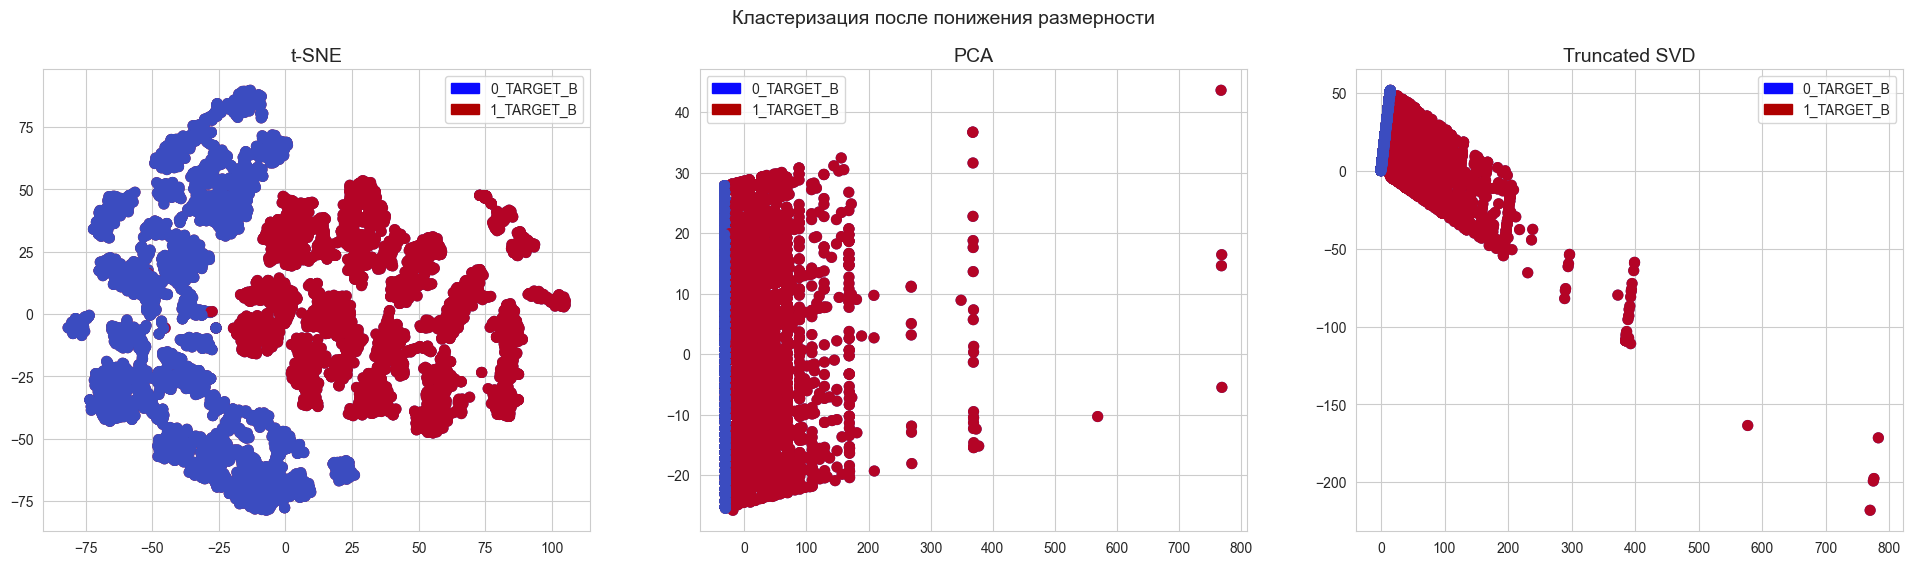

In [224]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Кластеризация после понижения размерности', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='0_TARGET_B')
red_patch = mpatches.Patch(color='#AF0000', label='1_TARGET_B')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 0), cmap='coolwarm', label='0_TARGET_B', linewidths=2)
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 1), cmap='coolwarm', label='1_TARGET_B', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 0), cmap='coolwarm', label='0_TARGET_B', linewidths=2)
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 1), cmap='coolwarm', label='1_TARGET_B', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 0), cmap='coolwarm', label='0_TARGET_B', linewidths=2)
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 1), cmap='coolwarm', label='1_TARGET_B', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

ПОПРОБУЕМ ВЫБРАТЬ ПРИЗНАКИ У КОТОРЫХ ЕСТЬ ХОТЬ КАКАЯ-ТО КОРРЕЛЯЦИЯ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ.

In [220]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

X = new_df[
    ['TARGET_D', 'FREQUENCY_STATUS_97NK', 'FILE_CARD_GIFT', 'RECENT_CARD_RESPONSE_COUNT', 'RECENT_CARD_RESPONSE_PROP']]
y = new_df['TARGET_B']

# T-SNE алгоритм
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE заняло {:.2} сек".format(t1 - t0))

# PCA алгоритм
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA заняло {:.2} сек".format(t1 - t0))

# TruncatedSVD алгоритм
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD заняло {:.2} сек".format(t1 - t0))


T-SNE заняло 1.6e+01 сек
PCA заняло 0.0025 сек
Truncated SVD заняло 0.0041 сек


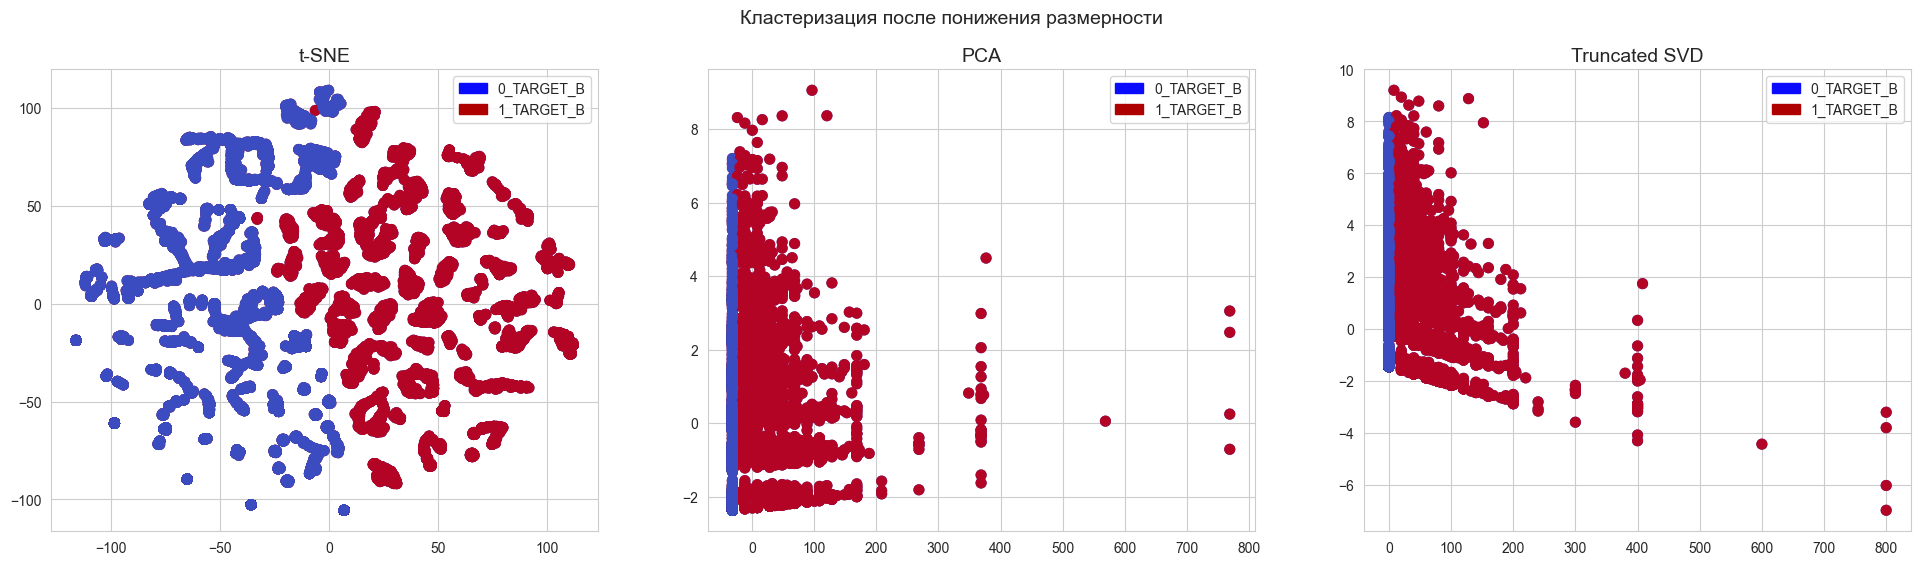

In [221]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Кластеризация после понижения размерности', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='0_TARGET_B')
red_patch = mpatches.Patch(color='#AF0000', label='1_TARGET_B')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 0), cmap='coolwarm', label='0_TARGET_B', linewidths=2)
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 1), cmap='coolwarm', label='1_TARGET_B', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 0), cmap='coolwarm', label='0_TARGET_B', linewidths=2)
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 1), cmap='coolwarm', label='1_TARGET_B', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 0), cmap='coolwarm', label='0_TARGET_B', linewidths=2)
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 1), cmap='coolwarm', label='1_TARGET_B', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [242]:
X = new_df[
    ['TARGET_D', 'FREQUENCY_STATUS_97NK', 'FILE_CARD_GIFT', 'RECENT_CARD_RESPONSE_COUNT', 'RECENT_CARD_RESPONSE_PROP']]
y = new_df['TARGET_B']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42)

# Переводим данные в массив для подачи в классификатор
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Выберем несколько простых моделей из библиотеки sklearn

classifiers = {
    "LogisiticRegression": LogisticRegression(),  # Логистическая регрессия
    "KNearest": SVC(),  # Метод опорных векторов
    "Support Vector Classifier": KNeighborsClassifier(),  # Метод ближайших соседей
    "DecisionTreeClassifier": DecisionTreeClassifier()  # Решающее дерево
}


In [243]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Модель ", classifier.__class__.__name__, "получила на обучающей выборке", round(training_score.mean(), 2) * 100, "% accuracy score")

Модель  LogisticRegression получила на обучающей выборке 100.0 % accuracy score
Модель  SVC получила на обучающей выборке 100.0 % accuracy score
Модель  KNeighborsClassifier получила на обучающей выборке 100.0 % accuracy score
Модель  DecisionTreeClassifier получила на обучающей выборке 100.0 % accuracy score


## Undersampling

In [291]:
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from collections import Counter
from sklearn.metrics import (precision_score, roc_auc_score, recall_score, f1_score, classification_report,
                             confusion_matrix, roc_curve, precision_recall_curve, accuracy_score)

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

undersample_X = df_normal.drop('TARGET_B', axis=1)
undersample_y = df_normal['TARGET_B']

undersample_Xtrain, undersample_Xtest, undersample_ytrain, undersample_ytest = train_test_split(undersample_X, undersample_y,
                                                                                                test_size = 0.25,
                                                                                                random_state=42,
                                                                                                stratify = undersample_y)#

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Метод NearMiss
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss распределение классов: {}'.format(Counter(y_nearmiss)))
# Использовать сэмплирование будем во время кросс-валидации

log_reg=LogisticRegression()

for train, test in skf.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)#
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])#
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])#

    undersample_accuracy.append(undersample_pipeline.score(undersample_Xtrain[test],
                                                           undersample_ytrain[test]))
    undersample_precision.append(precision_score(undersample_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(undersample_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(undersample_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(undersample_ytrain[test], undersample_prediction))

print(undersample_accuracy,undersample_precision,undersample_recall, undersample_f1)

NearMiss распределение классов: Counter({np.int64(0): 4843, np.int64(1): 4843})
[1.0, 1.0, 0.9993117687543015, 0.9996558843771507, 0.9993115318416523] [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9972527472527473)] [np.float64(1.0), np.float64(1.0), np.float64(0.9972489683631361), np.float64(0.9986244841815681), np.float64(1.0)] [np.float64(1.0), np.float64(1.0), np.float64(0.9986225895316805), np.float64(0.9993117687543015), np.float64(0.9986244841815681)]


In [257]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
import seaborn as sns

In [258]:
def plot_learning_curves(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)

    # Первая модель
    train_sizes, train_scores, test_scores = learning_curve(estimator1, X, y, cv=cv,
                                                            n_jobs=n_jobs, train_sizes=train_sizes)#
    train_scores_mean = np.mean(train_scores, axis=1)#
    train_scores_std = np.std(train_scores, axis=1)#
    test_scores_mean = np.mean(test_scores, axis=1)#
    test_scores_std = np.std(test_scores, axis=1)#
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Размер выборки')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

    # Вторая модель
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Размер выборки')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")


    # Третья модель
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Размер выборки")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")


    # Четвертая модель
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Размер выборки")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")

    return plt

<module 'matplotlib.pyplot' from '/Users/julia_dino/miniconda3/envs/Operon_Mapper/lib/python3.11/site-packages/matplotlib/pyplot.py'>

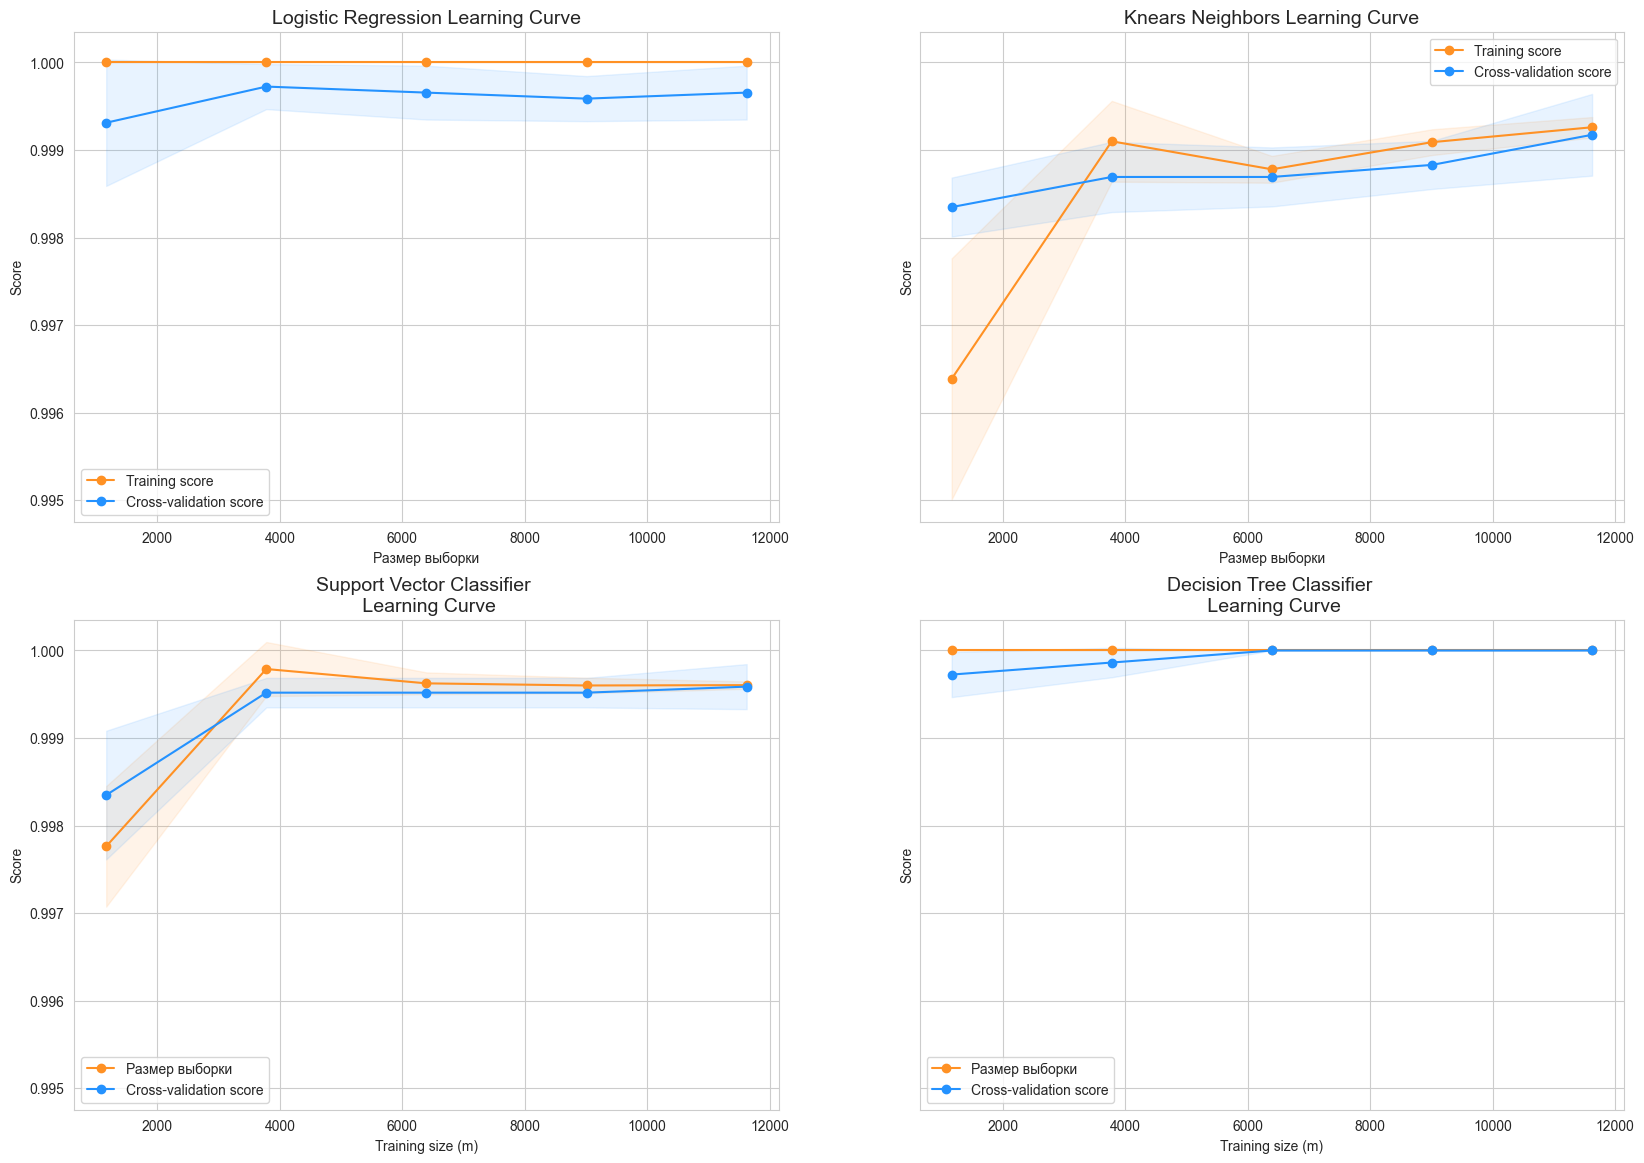

In [261]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

knears_neighbors = KNeighborsClassifier()
svc = SVC()
tree_clf = DecisionTreeClassifier()

plot_learning_curves(log_reg, knears_neighbors, svc, tree_clf, undersample_Xtrain, undersample_ytrain)

In [264]:
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, undersample_Xtrain, undersample_ytrain, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, undersample_Xtrain, undersample_ytrain, cv=5)

svc_pred = cross_val_predict(svc, undersample_Xtrain, undersample_ytrain, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, undersample_Xtrain, undersample_ytrain, cv=5)

In [265]:
print('Logistic Regression: ', roc_auc_score(undersample_ytrain, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(undersample_ytrain, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(undersample_ytrain, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(undersample_ytrain, tree_pred))

Logistic Regression:  0.9999948708754258
KNears Neighbors:  0.9983480176211454
Support Vector Classifier:  0.9999997726003884
Decision Tree Classifier:  1.0


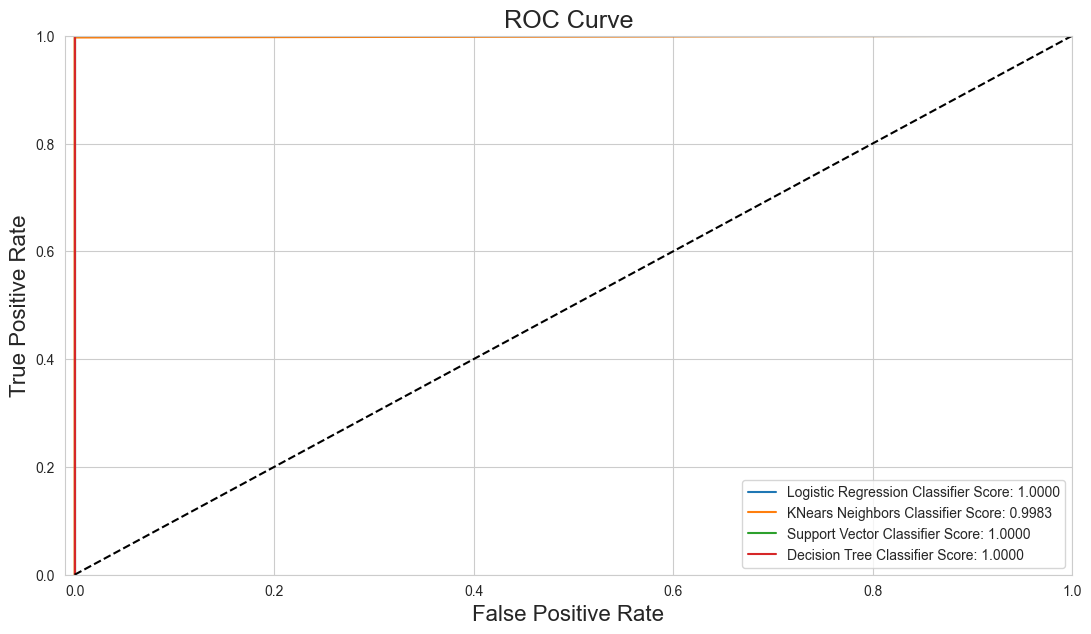

In [273]:
log_fpr, log_tpr, log_thresold = roc_curve(undersample_ytrain, log_reg_pred)#
knear_fpr, knear_tpr, knear_threshold = roc_curve(undersample_ytrain, knears_pred)#
svc_fpr, svc_tpr, svc_threshold = roc_curve(undersample_ytrain, svc_pred)#
tree_fpr, tree_tpr, tree_threshold = roc_curve(undersample_ytrain, tree_pred)#


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(13,7))
    plt.title('ROC Curve', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(undersample_ytrain, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(undersample_ytrain, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(undersample_ytrain, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(undersample_ytrain, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## SMOTE метод (Over-Sampling)

In [287]:
#Over Sampling and under sampling libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Machine learning Pipeline libraries
from imblearn.pipeline import Pipeline

# here we are using the imbalanced dataset
X = df_normal.drop('TARGET_B', axis=1)
y = df_normal['TARGET_B']

# StratifiedKFold is used for cross validation
# This cross-validation object is a variation of KFold that returns stratified folds.
# The folds are made by preserving the percentage of samples for each class.
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# creating the object for Over Sampling the minority class
over = SMOTE(sampling_strategy=0.4,k_neighbors=5)

# creating the object for Under Sampling the majority class
under = RandomUnderSampler(sampling_strategy=0.5)

for key, classifier in classifiers.items():

    # list of steps to be provided to the ML Pipeline
    steps=[('o',over),('u',under),('model',classifier)]

    # Creating a ML Pipeline
    FiPipeline=Pipeline(steps=steps)

    # Cross validating the classifiers
    scores=cross_val_score(FiPipeline,X,y,cv=sss)

    # Printing the mean accuracy score
    print(f"Classifiers: {key} Has a training score of, {round(scores.mean() * 100, 2)} % accuracy score")

Classifiers: LogisiticRegression Has a training score of, 99.97 % accuracy score
Classifiers: KNearest Has a training score of, 99.95 % accuracy score
Classifiers: Support Vector Classifier Has a training score of, 99.93 % accuracy score
Classifiers: DecisionTreeClassifier Has a training score of, 100.0 % accuracy score


In [292]:
# Логистическая регрессия с under-sampling
y_pred = log_reg.predict(undersample_Xtest)
undersample_score = accuracy_score(undersample_ytest, y_pred)

model = Pipeline([
        ('sampling', SMOTE(sampling_strategy=0.4)),
        ('Random',RandomUnderSampler(sampling_strategy=0.5)),
        ('classification', log_reg)
    ])

# Логистическая регрессия с over-sampling
y_pred_sm = model.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Метод': ['Random Under-Sampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

final_df

,Метод,Score
0,Random Under-Sampling,0.997316
1,Oversampling (SMOTE),0.997935
